<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>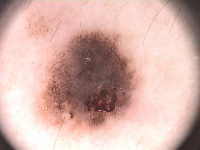</td><td>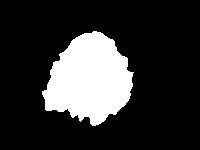</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'data/PH2Dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

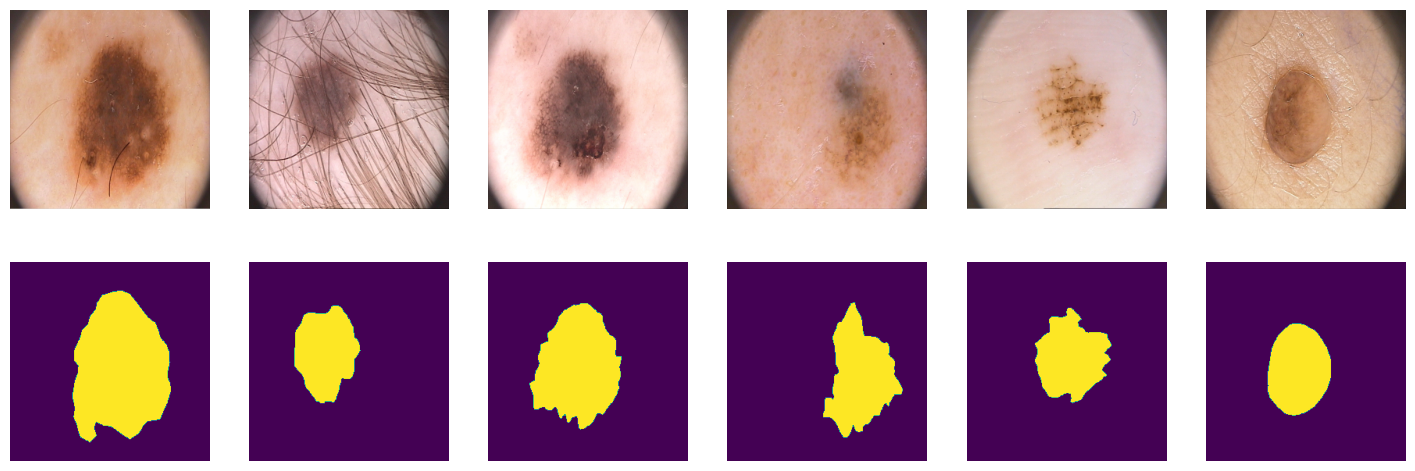

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [7]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [10]:
!pip install torchmetrics

   ---------------------------------------- 0.0/961.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/961.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/961.5 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/961.5 kB ? eta -:--:--
   --------------------- ------------------ 524.3/961.5 kB 1.7 MB/s eta 0:00:01
   -------------------------------- ------- 786.4/961.5 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 961.5/961.5 kB 1.4 MB/s eta 0:00:00


In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

---

$$ \log(1-\sigma(\hat y_i)) = \log(1-\frac{1}{1+exp(-\hat y_i)}=\log(\frac{exp(-\hat y_i)}{1+exp(-\hat y_i)})=\log(exp(-\hat y_i))-\log(1+exp(-\hat y_i))=-(\hat y_i+\log(1+exp(-\hat y_i))).$$

---

$$\begin{aligned} \mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] = - \sum_i \left[y_i \times(- log(1+exp(-\hat y_i)) - (1-y_i)(\hat y_i+\log(1+exp(-\hat y_i)))\right] \\ = -\sum_i \left[y_i \times(- log(1+exp(-\hat y_i)) - \hat y_i-\log(1+exp(-\hat y_i))+y_i\times\hat y_i +y_i\log(1+exp(-\hat y_i))\right] = - \sum_i\left[ -\hat y_i - \log(1+exp(-\hat y_i) +y_i\times\hat y_i\right] = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \end{aligned}$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [18]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [22]:
def bce_loss(y_pred, y_real):
  loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
  return torch.sum(loss)
  

def bce_true(y_pred, y_real):
  loss = y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred))
  return - torch.sum(loss)

Проверим корректность работы на простом примере

In [23]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.238532066345215
BCE loss честно посчитанный = 4.238532066345215
BCE loss from torch bce_torch = 4.238532066345215
BCE loss from torch with logits bce_torch = 4.238532066345215


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [24]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [25]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 12.828818321228027
BCE loss честно посчитанный = 12.828818321228027
BCE loss from torch bce_torch = 12.828818321228027
BCE loss from torch with logits bce_torch = 12.828819274902344


In [26]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [27]:
path_to_dummy_samples = './data/'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

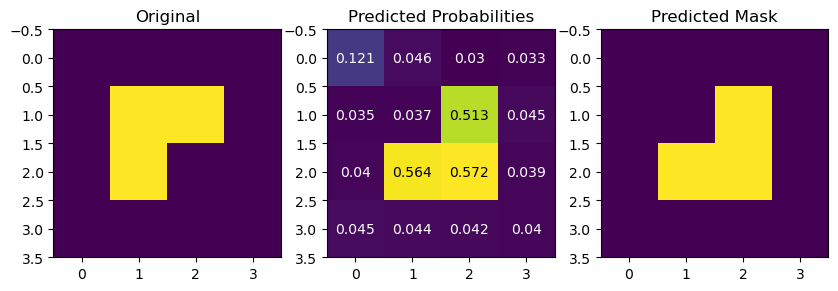

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [29]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

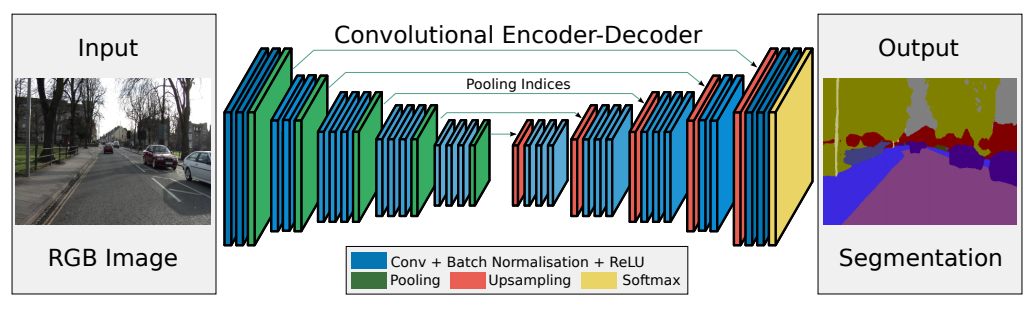

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


Тут я ~~украл~~ адаптировал код с medium

In [31]:
class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [32]:
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind

In [33]:
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

In [34]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=64):
        super().__init__()

        # Encoder
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # Bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3) 
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3) 

        # Decoder
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True) # No activation

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x) 
        e1, ind1 = self.enc1(e0) 
        e2, ind2 = self.enc2(e1) 
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        # classification layer
        output = self.dec3(d2, ind0)  
        return output

In [35]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [42]:
from tqdm.notebook import tqdm

In [56]:
def validate(model, valid_dataloader, criterion):
  iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to('cuda')
  model.eval()

  avg_loss = 0
  avg_iou = 0
  with torch.no_grad():
    for X_batch, Y_batch in tqdm(valid_dataloader):
        X_batch = X_batch.to('cuda')
        Y_batch = Y_batch.to('cuda')

        Y_pred = model(X_batch).to('cuda')
        iou = iou_score(Y_pred, Y_batch)
        loss = criterion(Y_pred, Y_batch)
        avg_loss += loss
        avg_iou += iou

  avg_loss = avg_loss/len(valid_dataloader)
  avg_iou = avg_iou/len(valid_dataloader)

  return avg_loss, avg_iou

In [57]:
def train(model, train_dataloader, valid_dataloader, optimizer, criterion, epochs, path):
    train_losses = []
    val_losses = []
    val_iou = []
    model.to('cuda')

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for X_batch, y_batch in tqdm(train_dataloader):
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            avg_loss += loss

        train_loss = avg_loss/len(train_dataloader)
        train_losses.append(train_loss)

        val_loss, avg_iou = validate(model, valid_dataloader, criterion)
        val_losses.append(val_loss)
        val_iou.append(avg_iou)
        
        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {avg_iou}')
        
        torch.save(model.state_dict(), f'{path}_{epoch}_epoch.pt')
    
    return train_losses, val_losses, val_iou


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [260]:
bce_segnet_model = SegNet().to('cuda')
optimizer = torch.optim.Adam(bce_segnet_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
model_save_path = 'models/segnet/bce/bce_segnet_'
train_losses, val_losses, val_iou = train(bce_segnet_model, train_dataloader, valid_dataloader, optimizer, criterion, epochs=30, path=model_save_path)
bce_statistics = train_losses, val_losses, val_iou

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.6916389465332031
Epoch 0: val loss = 0.6899547576904297
Epoch 0: val iou = 0.0013235778314992785


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.605143666267395
Epoch 1: val loss = 0.8412410020828247
Epoch 1: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.49774158000946045
Epoch 2: val loss = 0.632141649723053
Epoch 2: val iou = 0.0008984289597719908


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.4201357662677765
Epoch 3: val loss = 0.6677911877632141
Epoch 3: val iou = 0.3617759346961975


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.38857847452163696
Epoch 4: val loss = 0.6874614357948303
Epoch 4: val iou = 0.34386980533599854


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.3649476170539856
Epoch 5: val loss = 0.7442065477371216
Epoch 5: val iou = 0.3339294195175171


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.3294920027256012
Epoch 6: val loss = 0.5269920229911804
Epoch 6: val iou = 0.5106375217437744


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.27313297986984253
Epoch 7: val loss = 0.7067219614982605
Epoch 7: val iou = 0.429505854845047


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.24866704642772675
Epoch 8: val loss = 1.0979211330413818
Epoch 8: val iou = 0.34961578249931335


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.2275155484676361
Epoch 9: val loss = 1.077552080154419
Epoch 9: val iou = 0.38045501708984375


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.27230679988861084
Epoch 10: val loss = 0.7366731762886047
Epoch 10: val iou = 0.48781704902648926


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.23352012038230896
Epoch 11: val loss = 0.3400709629058838
Epoch 11: val iou = 0.6679286956787109


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.2263946235179901
Epoch 12: val loss = 0.2370266318321228
Epoch 12: val iou = 0.7152862548828125


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.2415025383234024
Epoch 13: val loss = 0.24180668592453003
Epoch 13: val iou = 0.7515484094619751


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.21128931641578674
Epoch 14: val loss = 0.30002039670944214
Epoch 14: val iou = 0.6944077610969543


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.21234992146492004
Epoch 15: val loss = 0.29792138934135437
Epoch 15: val iou = 0.7350116968154907


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.20301663875579834
Epoch 16: val loss = 0.46102291345596313
Epoch 16: val iou = 0.6435956358909607


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.19040831923484802
Epoch 17: val loss = 0.3992767333984375
Epoch 17: val iou = 0.6461249589920044


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.1972217857837677
Epoch 18: val loss = 0.3052870035171509
Epoch 18: val iou = 0.6704045534133911


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.18559329211711884
Epoch 19: val loss = 0.4551785886287689
Epoch 19: val iou = 0.5808627605438232


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.21043039858341217
Epoch 20: val loss = 0.7051042318344116
Epoch 20: val iou = 0.3997483253479004


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.18588271737098694
Epoch 21: val loss = 0.5841811895370483
Epoch 21: val iou = 0.4361833930015564


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.20787793397903442
Epoch 22: val loss = 0.2704654633998871
Epoch 22: val iou = 0.6540310382843018


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.1767481118440628
Epoch 23: val loss = 0.48946520686149597
Epoch 23: val iou = 0.2853863835334778


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.19089744985103607
Epoch 24: val loss = 0.6740447282791138
Epoch 24: val iou = 0.1692715287208557


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25: train loss = 0.18864281475543976
Epoch 25: val loss = 0.23624545335769653
Epoch 25: val iou = 0.7197631597518921


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26: train loss = 0.16367661952972412
Epoch 26: val loss = 0.26410728693008423
Epoch 26: val iou = 0.7159321308135986


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27: train loss = 0.16348512470722198
Epoch 27: val loss = 0.1988065540790558
Epoch 27: val iou = 0.7655777335166931


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28: train loss = 0.17218974232673645
Epoch 28: val loss = 0.1974947154521942
Epoch 28: val iou = 0.7887893915176392


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29: train loss = 0.14984141290187836
Epoch 29: val loss = 0.27381181716918945
Epoch 29: val iou = 0.7136418223381042


In [70]:
def result(train_losses, val_losses, val_iou):
    train_losses = [x.cpu().item() for x in train_losses]
    val_losses = [x.cpu().item() for x in val_losses]
    val_iou = [x.cpu().item() for x in val_iou]

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(list(range(len(train_losses))), train_losses, label = 'train loss', marker='o')
    ax1.plot(list(range(len(val_losses))), val_losses, label = 'val loss', marker='o')
    ax2.plot(list(range(len(val_iou))), val_iou, label = 'val iou', marker='o')
    ax1.set_title("Loss")
    ax2.set_title("IoU")
    ax1.legend()
    plt.show()

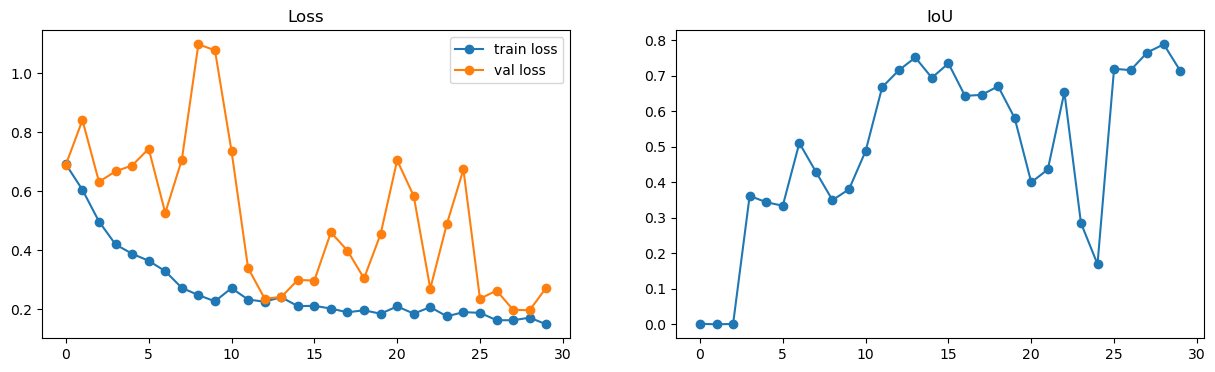

In [261]:
result(train_losses, val_losses, val_iou)

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
bce_segnet_model.load_state_dict(torch.load('models/segnet/bce/bce_segnet__28_epoch.pt'))
test_loss, test_iou = validate(bce_segnet_model, test_dataloader, criterion)
print(f'BCE Test loss: {test_loss}')
print(f'BCE Test iou: {test_iou}')

  0%|          | 0/2 [00:00<?, ?it/s]

Test loss: 0.2671893239021301
Test iou: 0.7346431016921997


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    # 2.1
    probs = torch.sigmoid(logits)
    # 2.2
    preds = (probs > threshold).float()
    # 2.3
    tp = torch.sum(preds * labels)
    fp = torch.sum(preds) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    # 2.4
    score = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return score

Проверим на корректность функцию dice_score:

In [91]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(average='micro', num_classes=1).to(device)
dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [92]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'].to(int), threshold=0.5)

tensor(0.6667, device='cuda:0')

In [94]:
assert dice(dummpy_sample['logits'].sigmoid() > 0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [123]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    # 3.1
    probs = torch.sigmoid(logits)

    # 3.3
    tp = torch.sum(probs * labels)
    fp = torch.sum(probs) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    # 3.4
    score = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    # 3.5
    loss = 1 - score
    
    return loss

Проверка на корректность:

In [98]:
pip install monai

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 2.3 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [124]:
from monai.losses import DiceLoss
dice_loss_torch = DiceLoss(sigmoid=True)
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [125]:
dice_loss(dummpy_sample['logits'], dummpy_sample['labels'].to(int))

tensor(0.5756, device='cuda:0')

хз тут авторы насрали по ощущениям с этими лоссами, как будто правильно считает, просто вопрос погрешности

In [126]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

AssertionError: 

In [115]:
assert torch.allclose(dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels']), dice_loss(dummpy_sample['logits'], dummpy_sample['labels']), atol=1e-6)

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [238]:
def focal_loss(y_pred, y_real : float, eps = 1e-8, gamma = 2):
    y_pred_sigmoid = torch.sigmoid(y_pred)

    p_t = y_pred_sigmoid * y_real + (1 - y_pred_sigmoid) * (1 - y_real)  # p_t по формуле

    focal_loss = ((1 - p_t) ** gamma) * nn.BCEWithLogitsLoss(reduction='none')(y_pred, y_real)

    return torch.sum(focal_loss)

Проверка корректности функции:

In [240]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [239]:
focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2)

tensor(3.6161, device='cuda:0')

In [237]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Я буду реализовывать Tversky loss

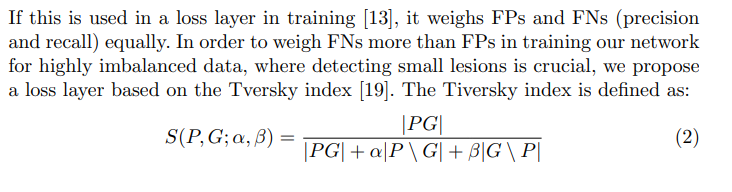
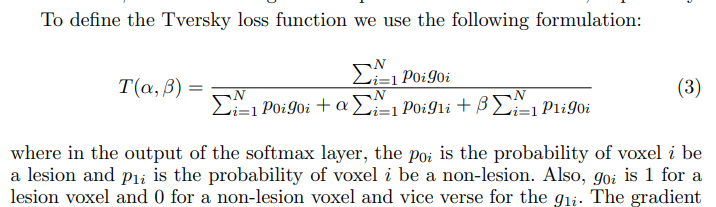

In [152]:
def tversky_loss(logits: torch.Tensor, labels: torch.Tensor, epsilon=1e-8, alpha=0.3):
    probs = torch.sigmoid(logits)

    tp = torch.sum(probs * labels)
    fp = torch.sum(probs) - tp
    fn = torch.sum(labels) - tp

    tversky_index = (tp + epsilon) / (tp + alpha*fp + (1-alpha)*fn + epsilon)
    
    loss = 1 - tversky_index
    return loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.5481560230255127
Epoch 0: val loss = 0.6277502775192261
Epoch 0: val iou = 0.30017703771591187


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.410959392786026
Epoch 1: val loss = 0.6321624517440796
Epoch 1: val iou = 0.00029275627457536757


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.3386862277984619
Epoch 2: val loss = 0.5301777720451355
Epoch 2: val iou = 0.30974966287612915


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.30151665210723877
Epoch 3: val loss = 0.49768954515457153
Epoch 3: val iou = 0.3458559513092041


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.2623186409473419
Epoch 4: val loss = 0.36028262972831726
Epoch 4: val iou = 0.5314435958862305


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.22005726397037506
Epoch 5: val loss = 0.37876608967781067
Epoch 5: val iou = 0.48534518480300903


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.2001744657754898
Epoch 6: val loss = 0.35999739170074463
Epoch 6: val iou = 0.4897337555885315


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.1763659119606018
Epoch 7: val loss = 0.2892457842826843
Epoch 7: val iou = 0.587114691734314


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.16016997396945953
Epoch 8: val loss = 0.2262079417705536
Epoch 8: val iou = 0.6747037172317505


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.1401529163122177
Epoch 9: val loss = 0.21212926506996155
Epoch 9: val iou = 0.7123886942863464


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.1375976949930191
Epoch 10: val loss = 0.19432249665260315
Epoch 10: val iou = 0.7294484376907349


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.13928616046905518
Epoch 11: val loss = 0.1570313274860382
Epoch 11: val iou = 0.7919878959655762


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.12290273606777191
Epoch 12: val loss = 0.17712083458900452
Epoch 12: val iou = 0.764526903629303


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.11523211002349854
Epoch 13: val loss = 0.14086303114891052
Epoch 13: val iou = 0.7974986433982849


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.10940060019493103
Epoch 14: val loss = 0.16316121816635132
Epoch 14: val iou = 0.7568461894989014


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.11392229795455933
Epoch 15: val loss = 0.1334822177886963
Epoch 15: val iou = 0.7995059490203857


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.11681473255157471
Epoch 16: val loss = 0.11170649528503418
Epoch 16: val iou = 0.8212984204292297


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.11947375535964966
Epoch 17: val loss = 0.1503218114376068
Epoch 17: val iou = 0.7548694610595703


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.13324037194252014
Epoch 18: val loss = 0.22694820165634155
Epoch 18: val iou = 0.6394027471542358


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.10183991491794586
Epoch 19: val loss = 0.20719978213310242
Epoch 19: val iou = 0.664620041847229


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.10075680911540985
Epoch 20: val loss = 0.19616907835006714
Epoch 20: val iou = 0.6786187887191772


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.13142651319503784
Epoch 21: val loss = 0.1251196563243866
Epoch 21: val iou = 0.7883298397064209


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.10780327022075653
Epoch 22: val loss = 0.1284256875514984
Epoch 22: val iou = 0.782322108745575


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.12682966887950897
Epoch 23: val loss = 0.10958194732666016
Epoch 23: val iou = 0.8098592758178711


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.0834941565990448
Epoch 24: val loss = 0.21454265713691711
Epoch 24: val iou = 0.6501481533050537


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25: train loss = 0.1070568710565567
Epoch 25: val loss = 0.27917230129241943
Epoch 25: val iou = 0.5721688866615295


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26: train loss = 0.09853793680667877
Epoch 26: val loss = 0.15306881070137024
Epoch 26: val iou = 0.7393847703933716


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27: train loss = 0.08965900540351868
Epoch 27: val loss = 0.10763496160507202
Epoch 27: val iou = 0.8121628761291504


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28: train loss = 0.08220690488815308
Epoch 28: val loss = 0.13496124744415283
Epoch 28: val iou = 0.7683318257331848


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29: train loss = 0.08779968321323395
Epoch 29: val loss = 0.14911174774169922
Epoch 29: val iou = 0.7464836835861206


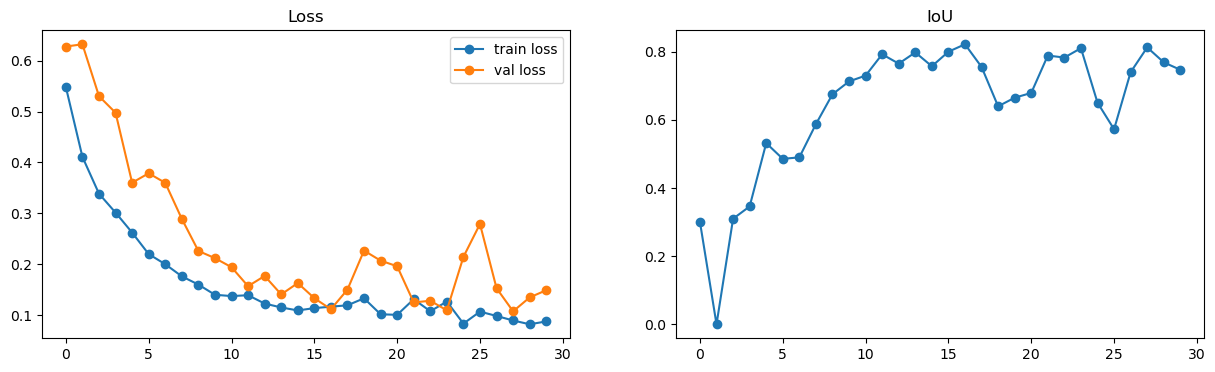

In [242]:
dice_segnet_model = SegNet().to('cuda')
optimizer = torch.optim.Adam(dice_segnet_model.parameters(), lr=0.001)
criterion = dice_loss
model_save_path = 'models/segnet/dice/dice_segnet_'
train_losses, val_losses, val_iou = train(dice_segnet_model, train_dataloader, valid_dataloader, optimizer, criterion, epochs=30, path=model_save_path)
dice_statistics = [train_losses, val_losses, val_iou]
result(train_losses, val_losses, val_iou)

чёт модель ерундой занимается

In [259]:
dice_segnet_model.load_state_dict(torch.load('models/segnet/dice/dice_segnet__15_epoch.pt'))
test_loss, test_iou = validate(dice_segnet_model, test_dataloader, criterion)
print(f'Test loss: {test_loss}')
print(f'Test iou: {test_iou}')

  0%|          | 0/2 [00:00<?, ?it/s]

Test loss: 0.19089815020561218
Test iou: 0.7195332050323486


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 298268.6875
Epoch 0: val loss = 274583.8125
Epoch 0: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 266349.96875
Epoch 1: val loss = 1099441.25
Epoch 1: val iou = 0.0028643119148910046


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 240542.96875
Epoch 2: val loss = 258265.0
Epoch 2: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 200550.78125
Epoch 3: val loss = 247608.1875
Epoch 3: val iou = 1.6579711882513948e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 175542.015625
Epoch 4: val loss = 252613.765625
Epoch 4: val iou = 0.008331021293997765


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 173058.375
Epoch 5: val loss = 257827.625
Epoch 5: val iou = 0.05807207524776459


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 160605.15625
Epoch 6: val loss = 253621.640625
Epoch 6: val iou = 0.08387142419815063


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 144336.921875
Epoch 7: val loss = 350103.8125
Epoch 7: val iou = 0.14178557693958282


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 164993.34375
Epoch 8: val loss = 237107.703125
Epoch 8: val iou = 0.3193679451942444


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 145500.53125
Epoch 9: val loss = 170647.6875
Epoch 9: val iou = 0.6191383600234985


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 132342.453125
Epoch 10: val loss = 162805.71875
Epoch 10: val iou = 0.628127932548523


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 127043.484375
Epoch 11: val loss = 156728.25
Epoch 11: val iou = 0.6550170183181763


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 123120.53125
Epoch 12: val loss = 184527.859375
Epoch 12: val iou = 0.5914050936698914


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 110474.34375
Epoch 13: val loss = 130000.8828125
Epoch 13: val iou = 0.69317626953125


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 106512.7578125
Epoch 14: val loss = 144142.1875
Epoch 14: val iou = 0.6581257581710815


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 101234.59375
Epoch 15: val loss = 113734.4609375
Epoch 15: val iou = 0.7160096764564514


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 104274.7421875
Epoch 16: val loss = 162746.78125
Epoch 16: val iou = 0.624131441116333


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 100162.0234375
Epoch 17: val loss = 113194.765625
Epoch 17: val iou = 0.7137447595596313


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 90175.859375
Epoch 18: val loss = 97300.296875
Epoch 18: val iou = 0.7430595755577087


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 87937.828125
Epoch 19: val loss = 85979.65625
Epoch 19: val iou = 0.7570527195930481


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 85030.03125
Epoch 20: val loss = 85964.25
Epoch 20: val iou = 0.7669024467468262


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 88419.0390625
Epoch 21: val loss = 118159.09375
Epoch 21: val iou = 0.7327593564987183


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 95475.59375
Epoch 22: val loss = 125553.25
Epoch 22: val iou = 0.6939905285835266


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 83963.296875
Epoch 23: val loss = 93581.640625
Epoch 23: val iou = 0.7631785869598389


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 81802.234375
Epoch 24: val loss = 94433.59375
Epoch 24: val iou = 0.7587123513221741


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25: train loss = 80799.796875
Epoch 25: val loss = 86656.4921875
Epoch 25: val iou = 0.7755544185638428


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26: train loss = 105690.703125
Epoch 26: val loss = 99989.8125
Epoch 26: val iou = 0.7530418634414673


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27: train loss = 89403.046875
Epoch 27: val loss = 125855.2421875
Epoch 27: val iou = 0.7115401029586792


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28: train loss = 83443.0625
Epoch 28: val loss = 75570.46875
Epoch 28: val iou = 0.7897717952728271


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29: train loss = 76092.8125
Epoch 29: val loss = 80886.421875
Epoch 29: val iou = 0.7800058126449585


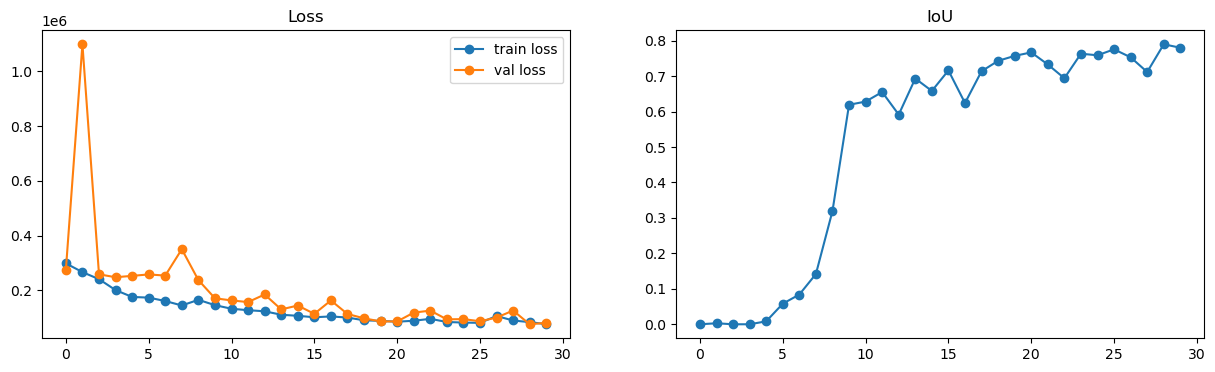

In [250]:
focal_segnet_model = SegNet().to('cuda')
optimizer = torch.optim.Adam(focal_segnet_model.parameters(), lr=0.001)
criterion = focal_loss
model_save_path = 'models/segnet/focal/focal_segnet_'
train_losses, val_losses, val_iou = train(focal_segnet_model, train_dataloader, valid_dataloader, optimizer, criterion, epochs=30, path=model_save_path)
focal_statistics = [train_losses, val_losses, val_iou]
result(train_losses, val_losses, val_iou)

In [251]:
focal_segnet_model.load_state_dict(torch.load('models/segnet/focal/focal_segnet__29_epoch.pt'))
test_loss, test_iou = validate(focal_segnet_model, test_dataloader, criterion)
print(f'Test loss: {test_loss}')
print(f'Test iou: {test_iou}')

  0%|          | 0/2 [00:00<?, ?it/s]

Test loss: 107067.0
Test iou: 0.7210288047790527


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 0.44863730669021606
Epoch 0: val loss = 0.5882004499435425
Epoch 0: val iou = 0.0003794918302446604


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train loss = 0.31328487396240234
Epoch 1: val loss = 0.5982525944709778
Epoch 1: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train loss = 0.2554556727409363
Epoch 2: val loss = 0.6310427188873291
Epoch 2: val iou = 0.005374445579946041


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train loss = 0.23470263183116913
Epoch 3: val loss = 0.6995565891265869
Epoch 3: val iou = 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train loss = 0.22413921356201172
Epoch 4: val loss = 0.4459109902381897
Epoch 4: val iou = 0.41357359290122986


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: train loss = 0.20185069739818573
Epoch 5: val loss = 0.3715486526489258
Epoch 5: val iou = 0.4864083528518677


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: train loss = 0.16720493137836456
Epoch 6: val loss = 0.2492711842060089
Epoch 6: val iou = 0.6369508504867554


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: train loss = 0.1497042179107666
Epoch 7: val loss = 0.19755473732948303
Epoch 7: val iou = 0.5849903225898743


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: train loss = 0.14644373953342438
Epoch 8: val loss = 0.15248245000839233
Epoch 8: val iou = 0.6950043439865112


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: train loss = 0.12681454420089722
Epoch 9: val loss = 0.14679968357086182
Epoch 9: val iou = 0.7099853157997131


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: train loss = 0.11830559372901917
Epoch 10: val loss = 0.13163143396377563
Epoch 10: val iou = 0.7197411060333252


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: train loss = 0.11279866099357605
Epoch 11: val loss = 0.1518048644065857
Epoch 11: val iou = 0.6697005033493042


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: train loss = 0.11128781735897064
Epoch 12: val loss = 0.18667671084403992
Epoch 12: val iou = 0.5816051959991455


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: train loss = 0.09550096094608307
Epoch 13: val loss = 0.19209089875221252
Epoch 13: val iou = 0.5730913877487183


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: train loss = 0.09798526763916016
Epoch 14: val loss = 0.22372576594352722
Epoch 14: val iou = 0.5218843817710876


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: train loss = 0.09507276117801666
Epoch 15: val loss = 0.14130181074142456
Epoch 15: val iou = 0.6745335459709167


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: train loss = 0.08561739325523376
Epoch 16: val loss = 0.1359119415283203
Epoch 16: val iou = 0.7010027170181274


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: train loss = 0.09376581013202667
Epoch 17: val loss = 0.12214821577072144
Epoch 17: val iou = 0.7207188606262207


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: train loss = 0.08924341201782227
Epoch 18: val loss = 0.1407870650291443
Epoch 18: val iou = 0.6699714660644531


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: train loss = 0.1046619862318039
Epoch 19: val loss = 0.2685363292694092
Epoch 19: val iou = 0.4534972310066223


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: train loss = 0.1067899614572525
Epoch 20: val loss = 0.21089571714401245
Epoch 20: val iou = 0.5357438921928406


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21: train loss = 0.09372061491012573
Epoch 21: val loss = 0.16078594326972961
Epoch 21: val iou = 0.6380072832107544


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22: train loss = 0.08420462906360626
Epoch 22: val loss = 0.10437217354774475
Epoch 22: val iou = 0.7753641605377197


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23: train loss = 0.08433760702610016
Epoch 23: val loss = 0.09560412168502808
Epoch 23: val iou = 0.827309250831604


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24: train loss = 0.08704186975955963
Epoch 24: val loss = 0.11249551177024841
Epoch 24: val iou = 0.780744194984436


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25: train loss = 0.09384369850158691
Epoch 25: val loss = 0.13078567385673523
Epoch 25: val iou = 0.6996922492980957


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26: train loss = 0.10942387580871582
Epoch 26: val loss = 0.15619823336601257
Epoch 26: val iou = 0.6333187818527222


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27: train loss = 0.09092317521572113
Epoch 27: val loss = 0.13483643531799316
Epoch 27: val iou = 0.6882443428039551


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28: train loss = 0.08381125330924988
Epoch 28: val loss = 0.11137935519218445
Epoch 28: val iou = 0.7354967594146729


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29: train loss = 0.09730759263038635
Epoch 29: val loss = 0.10844072699546814
Epoch 29: val iou = 0.7532396912574768


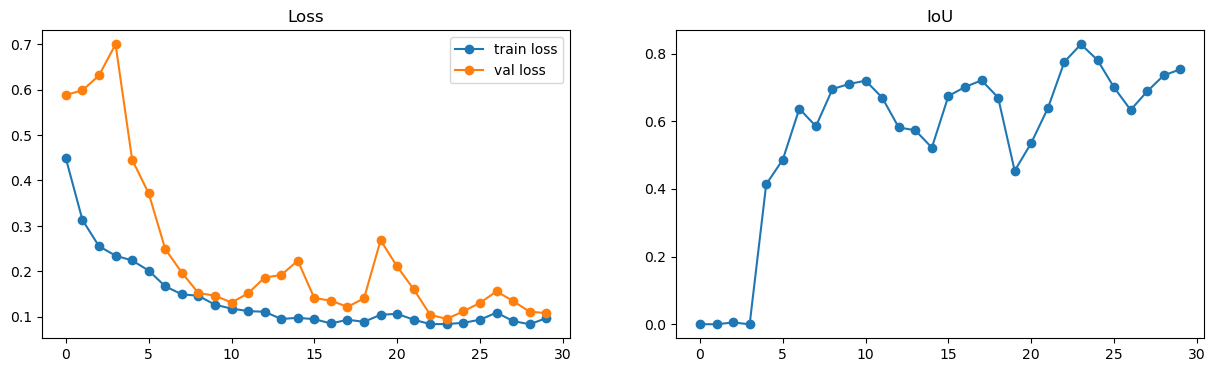

In [254]:
tversky_segnet_model = SegNet().to('cuda')
optimizer = torch.optim.Adam(tversky_segnet_model.parameters(), lr=0.001)
criterion = tversky_loss
model_save_path = 'models/segnet/tversky/tversky_segnet_'
train_losses, val_losses, val_iou = train(tversky_segnet_model, train_dataloader, valid_dataloader, optimizer, criterion, epochs=30, path=model_save_path)
tversky_statistics = [train_losses, val_losses, val_iou]
result(train_losses, val_losses, val_iou)

In [258]:
tversky_segnet_model.load_state_dict(torch.load('models/segnet/tversky/tversky_segnet__23_epoch.pt'))
test_loss, test_iou = validate(tversky_segnet_model, test_dataloader, criterion)
print(f'Test loss: {test_loss}')
print(f'Test iou: {test_iou}')

  0%|          | 0/2 [00:00<?, ?it/s]

Test loss: 0.17169106006622314
Test iou: 0.7224875688552856


In [270]:
def to_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    elif isinstance(data, list):
        return [x.detach().cpu().item() if isinstance(x, torch.Tensor) else x for x in data]
    return data

In [273]:
def plot_losses(IoU_BCE, IoU_Dice, IoU_Focal, IoU_Tversky, title):
    # Set up the figure and axis objects
    fig, ax = plt.subplots()

    # Plot each line with appropriate labels and formatting
    ax.plot(to_numpy(IoU_BCE), '-', label="BCE")
    ax.plot(to_numpy(IoU_Dice), '-', label="Dice")
    ax.plot(to_numpy(IoU_Focal), '-', label="Focal")
    ax.plot(to_numpy(IoU_Tversky), '-', label="Tversky")

    # Customize the title and legend
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("IoU Value")
    ax.legend(loc="upper left")

    # Display the plot
    plt.show()

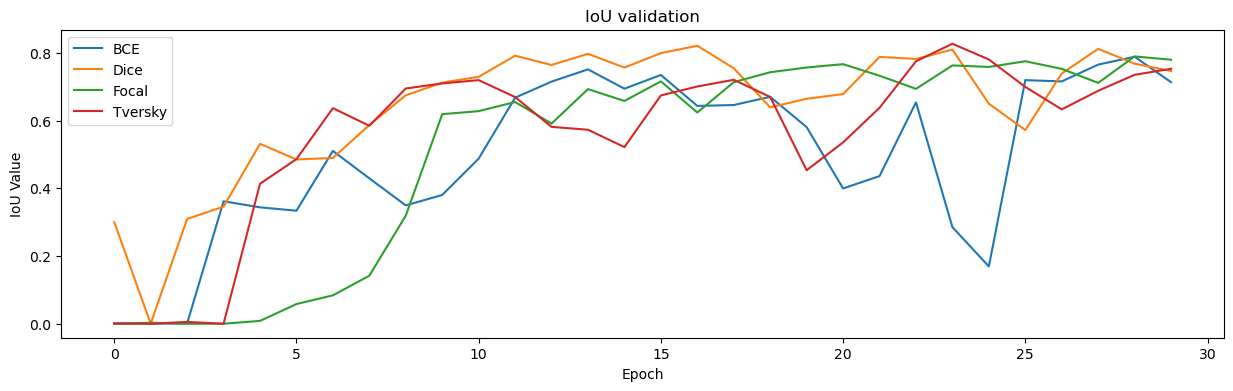

In [274]:
plot_losses(bce_statistics[2], dice_statistics[2],
            focal_statistics[2], tversky_statistics[2], "IoU validation")

In [267]:
bce_segnet_model.load_state_dict(torch.load('models/segnet/bce/bce_segnet__28_epoch.pt'))
test_loss, test_iou = validate(bce_segnet_model, test_dataloader, criterion)
print(f'BCE test loss: {test_loss}')
print(f'BCE test iou: {test_iou}')

dice_segnet_model.load_state_dict(torch.load('models/segnet/dice/dice_segnet__15_epoch.pt'))
test_loss, test_iou = validate(dice_segnet_model, test_dataloader, criterion)
print(f'Dice test loss: {test_loss}')
print(f'Dice test iou: {test_iou}')

focal_segnet_model.load_state_dict(torch.load('models/segnet/focal/focal_segnet__29_epoch.pt'))
test_loss, test_iou = validate(focal_segnet_model, test_dataloader, criterion)
print(f'Focal test loss: {test_loss}')
print(f'Focal test iou: {test_iou}')

tversky_segnet_model.load_state_dict(torch.load('models/segnet/tversky/tversky_segnet__23_epoch.pt'))
test_loss, test_iou = validate(tversky_segnet_model, test_dataloader, criterion)
print(f'Tversky test loss: {test_loss}')
print(f'Tversky test iou: {test_iou}')

  0%|          | 0/2 [00:00<?, ?it/s]

BCE test loss: 0.2671893239021301
BCE test iou: 0.7370024919509888


  0%|          | 0/2 [00:00<?, ?it/s]

Dice test loss: 0.42404672503471375
Dice test iou: 0.7208616733551025


  0%|          | 0/2 [00:00<?, ?it/s]

Focal test loss: 0.28802943229675293
Focal test iou: 0.722748339176178


  0%|          | 0/2 [00:00<?, ?it/s]

Tversky test loss: 0.7913719415664673
Tversky test iou: 0.7237853407859802


Вот такие пироги. Лучше всего себя на тесте показала BCE, хотя при обучении стабильнее была Dice

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

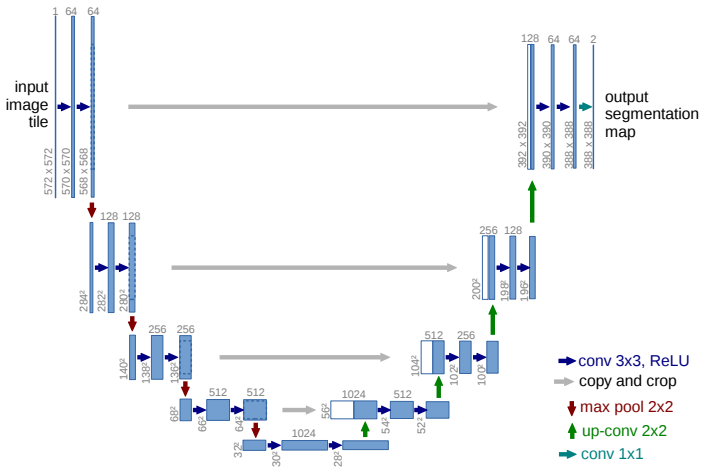

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # TODO

    def forward(self, x):
        #  TODO

        return output

In [ ]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

